# Установка библиотек

In [2]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\work_and_fun\partisans\PP\mistakes-and-regrets\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
# https://pypi.org/project/pgeocode/
# pip install pgeocode

In [4]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\work_and_fun\partisans\PP\mistakes-and-regrets\Scripts\python.exe -m pip install --upgrade pip' command.


In [5]:
pip install featuretools

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\work_and_fun\partisans\PP\mistakes-and-regrets\Scripts\python.exe -m pip install --upgrade pip' command.


# Импорт библиотек

In [6]:
import re
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pgeocode as geo
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, PolynomialFeatures, RobustScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, roc_auc_score
import phik
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from featuretools import encode_features as ef


import matplotlib
import geopandas as gpd

rs = 123

In [7]:
try:
    df = pd.read_csv('autos.csv')
    df = pd.read_csv('autos_with_geo.csv')

except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [8]:
try:
    top_cities = pd.read_csv('top_cities.csv')
except:
    top_cities = pd.read_csv('https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/geonames-all-cities-with-a-population-1000/exports/csv?lang=en&timezone=Europe%2FMinsk&use_labels=true&delimiter=%3B', sep=';')

Сразу удалим дубликаты

In [9]:
print(f'Было {df.duplicated().sum()} полных дубликатов')
df = df.drop_duplicates()
print(f'Осталось {df.duplicated().sum()} полных дубликатов')

Было 4 полных дубликатов
Осталось 0 полных дубликатов


Взглянем на данные

In [10]:
df.sample(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,PlaceName,StateName,Latitude,Longitude
217458,2016-03-15 20:36:51,1500,wagon,2003,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-15 00:00:00,0,6773,2016-03-15 20:36:51,NaN,NaN,NaN,NaN
194548,2016-04-04 20:44:08,3300,sedan,2000,auto,101,a3,125000,7,petrol,audi,no,2016-04-04 00:00:00,0,22147,2016-04-06 22:46:43,"Hamburg, Hamburg Rahlstedt",Hamburg,53.6092,10.1481
147066,2016-03-28 18:57:45,1950,bus,2004,manual,140,other,150000,4,NaN,citroen,yes,2016-03-28 00:00:00,0,40764,2016-04-07 01:16:12,Langenfeld,Nordrhein-Westfalen,51.1082,6.9483


Переименуем названия колонок

In [11]:
df.columns = ['_'.join(words).lower() for words in [re.findall(r'([A-Z]{1}[a-z]+)', el) for el in df.columns]]

Напишем функцию, выводящую всю статистическую информацию по датасету

In [12]:
def full_info(df):
    display(pd.DataFrame({'Non-Null Count': (~df.isna()).sum(),
                          'Null Count': df.isna().sum(),
                          'Dtype': df.dtypes}).join(df.describe().T).rename_axis('Feature', axis=1).fillna(''))

In [13]:
full_info(df)

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
date_crawled,354365,0,object,,,,,,,,
price,354365,0,int64,354365.0,4416.67983,4514.176349,0.0,1050.0,2700.0,6400.0,20000.0
vehicle_type,316875,37490,object,,,,,,,,
registration_year,354365,0,int64,354365.0,2004.234481,90.228466,1000.0,1999.0,2003.0,2008.0,9999.0
gearbox,334532,19833,object,,,,,,,,
power,354365,0,int64,354365.0,110.093816,189.85133,0.0,69.0,105.0,143.0,20000.0
model,334660,19705,object,,,,,,,,
kilometer,354365,0,int64,354365.0,128211.363989,37905.083858,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354365,0,int64,354365.0,5.71465,3.726432,0.0,3.0,6.0,9.0,12.0
fuel_type,321470,32895,object,,,,,,,,


Наблюдения следующие
- В пяти колонках есть пропуски
- в колонке number_of_pictures одни нули
- Типы данных неоптимальны

# EDA

По порядку пройдем по всем признакам

## price

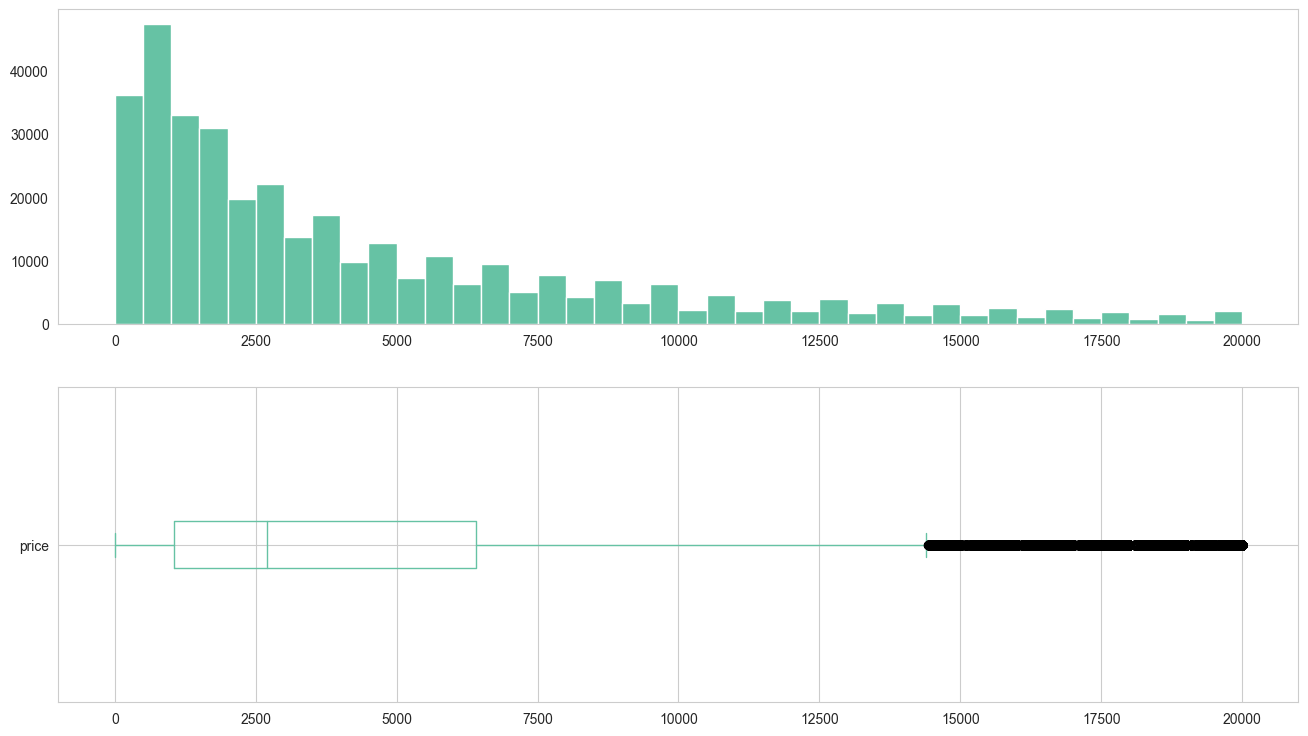

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 9))
df['price'].hist(grid=False, bins=40, color='#66c2a4', ax=ax1);
df['price'].plot.box(grid=True, vert=False, color='#66c2a4', ax=ax2);

Для цен характерно распределение Пуассона, оставим только объявления дороже 300 евро. А 20 тыс - нормальная цена для хорошего авто

In [15]:
df = df[df['price']>300]

## number_of_pictures

In [16]:
try:
    print(f'в датасете {df["number_of_pictures"].unique()[0]} уникальных значений в поле с числом фотографий')
    df = df.drop('number_of_pictures', axis=1)
except:
    print('Столбец уже удален')

в датасете 0 уникальных значений в поле с числом фотографий


Фотографий нет ни у кого

## postal_code

У нас есть колонка с почтовым индексом. Возможно, по ней удастся установить географию объявлений. При помощи библиотеки pgeocode добавим в датасет название населенного пункта и области, а также долготу и широту/
В следующий раз для зипкодов нужно попробовать [вот это](https://woodwork.alteryx.com/en/v0.7.1/generated/woodwork.logical_types.PostalCode.html). Это что-то более поддерживаемое

In [17]:
nomi = geo.Nominatim('DE')
def postal_coder(row):
    res = nomi.query_postal_code(row)
    return res['place_name'], res['state_name'], res['latitude'], res['longitude']

In [18]:
%%time
df['postal_code'].head(10).apply(postal_coder)

CPU times: total: 46.9 ms
Wall time: 44 ms


0     (Stuttgart, Stuttgart Zuffenhausen, Baden-Würt...
1         (Pirmasens, Rheinland-Pfalz, 49.2071, 7.5911)
2                  (Nürnberg, Bayern, 49.4371, 11.1194)
3             (Herzogenaurach, Bayern, 49.568, 10.8856)
4          (Frankfurt am Main, Hessen, 50.1924, 8.6753)
5      (Versmold, Nordrhein-Westfalen, 52.0401, 8.1527)
6       (Mutterstadt, Rheinland-Pfalz, 49.4414, 8.3561)
8                  (Bernried, Bayern, 48.9167, 12.8833)
9             (Cuxhaven, Niedersachsen, 53.8584, 8.709)
10              (Burgkunstadt, Bayern, 50.1409, 11.252)
Name: postal_code, dtype: object

Функция работает довольно долго, поэтому мы воспроизвели датасет из сохраненного заранее файла

In [19]:
# %%time
# df['PlaceName'], df['StateName'], df['Latitude'], df['Longitude'], = zip(*df['PostalCode'].apply(postal_coder))

In [20]:
print(f'Геоданные не найдены для {df["place_name"].isna().sum()} записей')

Геоданные не найдены для 15984 записей


Пока не убедимся, что признаки полезны, не будем удалять эти записи

In [21]:
# %%time
# top_cities = pd.read_csv('https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/geonames-all-cities-with-a-population-1000/exports/csv?lang=en&timezone=Europe%2FMinsk&use_labels=true&delimiter=%3B', sep=';')

top_cities = top_cities[top_cities['LABEL EN']=='Germany'].sort_values('Population', ascending=False)[['Name', 'Coordinates', 'Population']]

top_cities['latitude'] = top_cities['Coordinates'].apply(lambda x: x.split(',')[0])
top_cities['longitude'] = top_cities['Coordinates'].apply(lambda x: x.split(',')[1])
top_cities.drop('Coordinates', axis=1, inplace=True)

top_cities['longitude'] = top_cities['longitude'].astype('float')
top_cities['latitude'] = top_cities['latitude'].astype('float')

# Два города накладываются друг на друга
top_cities = top_cities[top_cities['Name']!='Großzschocher']

Посмотрим, сколько городов дублируется

In [22]:
print(f'{top_cities.shape[0]-top_cities["Name"].nunique()} городов повторяется. Надо удалить')

352 городов повторяется. Надо удалить


In [23]:
top_cities = top_cities.drop_duplicates('Name')

In [24]:
top_cities

,Name,Population,latitude,longitude
10924,Berlin,3426354,52.52437,13.41053
114885,Hamburg,1845229,53.55073,9.99302
124321,Munich,1260391,48.13743,11.57549
11720,Köln,963395,50.93333,6.95000
18203,Frankfurt am Main,650000,50.11552,8.68417
...,...,...,...,...
27463,Falkenfels,1001,49.00415,12.59480
78533,Pfeffelbach,1001,49.53948,7.32768
93507,Burg Unter-Falkenstein,0,47.70440,12.10466
61814,Haselbachtal,0,51.23570,14.02576


In [25]:
tmp = df.groupby('postal_code').agg(longitude=('longitude', 'first'),
                                         latitude=('latitude', 'first'),
                                         count=('place_name', 'count'),
                                         median=('price', 'median')).query('count>20')
tmp

,longitude,latitude,count,median
postal_code,,,,
10115,13.384600,52.532300,809,10500.0
10117,13.387200,52.517000,64,4625.0
10119,13.405300,52.530500,47,2850.0
10178,13.409600,52.521300,52,4000.0
10179,13.416400,52.512200,41,3500.0
...,...,...,...,...
99894,10.591633,50.852300,32,3515.0
99897,10.615700,50.792500,21,2000.0
99947,10.638018,51.157027,65,3000.0


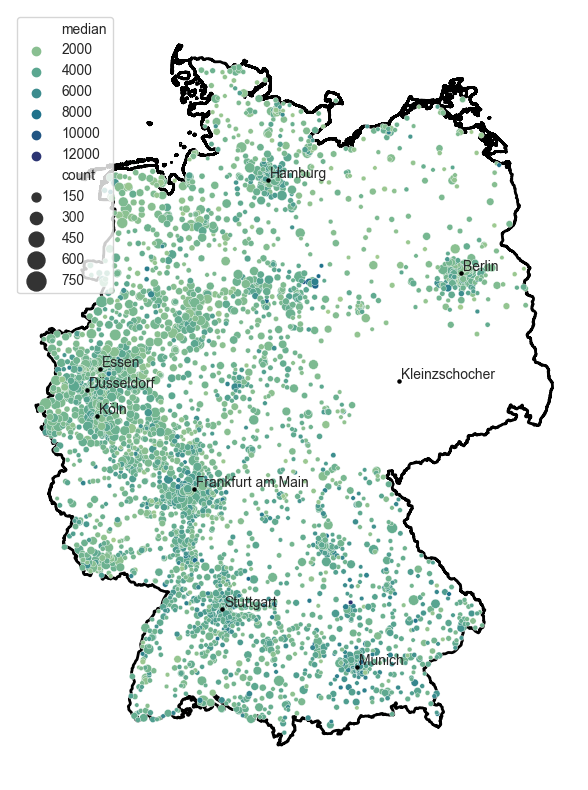

In [26]:
germany = gpd.read_file('https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/main/1_deutschland/1_sehr_hoch.geo.json')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
germany.plot(ax=ax, color='white', edgecolor='k', linewidth=2)

sns.scatterplot(data=tmp,
                y='latitude',
                x='longitude',
                hue='median',
                palette='crest',
                size='count',
                sizes=(10, 200), ax=ax);

ax.scatter(top_cities['longitude'].head(9), top_cities['latitude'].head(9), c='k', s=5)
for row in top_cities.head(9).iterrows():
    ax.annotate(text=row[1]['Name'],
                xy=(row[1]['longitude'], row[1]['latitude']),
                xytext=(1.5, 1.5),
                textcoords='offset points')

ax.axis('off')
ax.legend(loc='upper left')
ax.grid(False);

По какой-то причине не распознались почтовые индексы на востоке Германии, ~~а карта покрылась плесенью~~

Добавим в таблицу население городов, но прежде проверим, население скольких городов мы не знаем

In [27]:
%%time
# df['place_name'].apply(lambda x: 0 if x in top_cities['Name'].values else 1).sum()

CPU times: total: 0 ns
Wall time: 0 ns


Почти треть. Можно было бы добавить население ближайшего по координатам города, но функция будет слишком долго работать

In [28]:
df = pd.merge(df, top_cities.set_index('Name')['Population'], left_on='place_name', right_index=True, how='left')

In [29]:
df = df.rename({'Population': 'population'}, axis=1)

In [30]:
print(f'Координаты неизвестны для {df["latitude"].isna().sum()/df["latitude"].shape[0]:.1%} записей')
print(f'Население неизвестно для {df["population"].isna().sum()/df["population"].shape[0]:.1%} записей')

Координаты неизвестны для 4.9% записей
Население неизвестно для 27.9% записей


Добавить координаты и плотность населения не удалось для большого числа записей, пропуски нужно чем-то заполнить. Первое, что приходит в голову, это заполнить средним/медианой, но судя по карте, пропуски имеют закономерность - большинство из них расположены на востоке Германии, а заполнение средним наоборот поместит их на запад. Но проект учебный, так что ничего страшного

Названия населенных пунктов и регионов слишком увеличат размерность, так что их стоит удалить

In [31]:
df = df.drop(['place_name', 'state_name'], axis=1)

## date_crawled

In [32]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'])

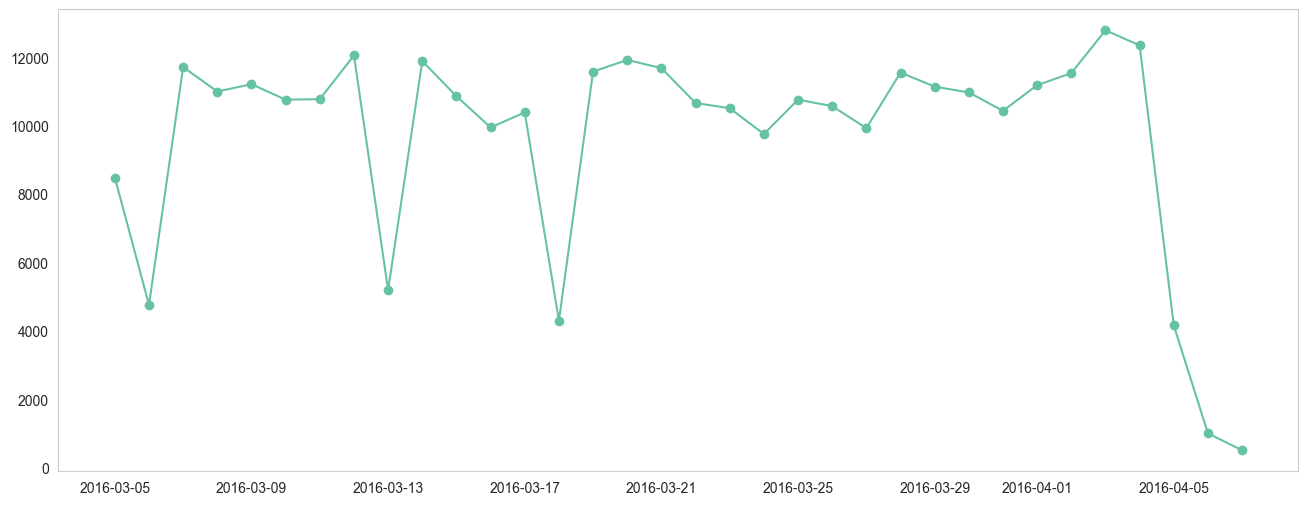

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
df['date_crawled'].dt.date.value_counts().plot(grid=False, marker='o', color='#66c2a4', ax=ax);

## brand

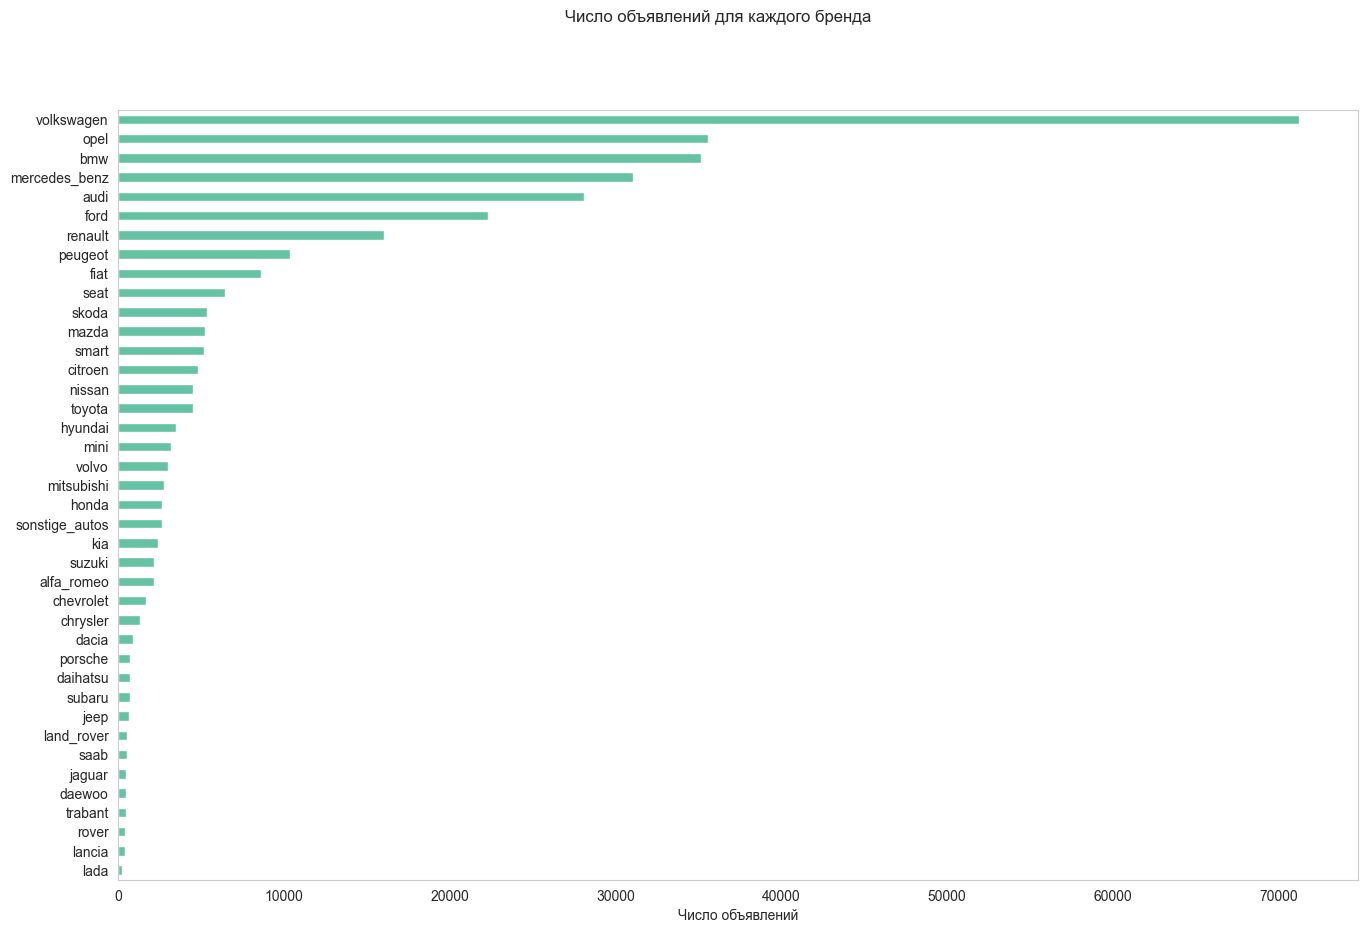

In [34]:
df['brand'].value_counts()[::-1].plot.barh(figsize=(16, 10), color='#66c2a4',grid=False);
plt.suptitle('Число объявлений для каждого бренда')
plt.xlabel('Число объявлений');

Много брендов встречаются всего в нескольких сотнях объявлений

## model

У разных брендов модели могут называться одинаково. Проверим это

In [35]:
df.groupby('model')['brand'].nunique().sort_values().tail(10)

model
corsa          1
3_reihe        2
matiz          2
5_reihe        2
1_reihe        2
defender       2
freelander     2
discovery      2
grand          3
other         39
Name: brand, dtype: int64

Надеемся, третий рейх это безобидное обозначение поколения автомобиля

Посмотрим, под какими брендами выпускается Дефендер

In [36]:
df[df['model']=='defender']['brand'].unique()

array(['land_rover', 'rover'], dtype=object)

Кажется, это один бренд, объединим такие записи

In [37]:
df.loc[:, 'brand'] = df['brand'].replace({'rover': 'land_rover'})

Много моделей не опознано. Заменим их на other

In [38]:
df.loc[:, 'model'] = df['model'].fillna('other')

Анализ показал, что у разных брендов модели могут называться одинаково, поэтому добавим в поле с моделью имя бренда

In [39]:
df.loc[:, 'model'] = df.apply(lambda x: ' '.join([x['brand'], x['model']]), axis=1)

In [40]:
df['model'].sample(3)

343380          ford escort
319834       volkswagen fox
339344    mitsubishi pajero
Name: model, dtype: object

## vehicle_type

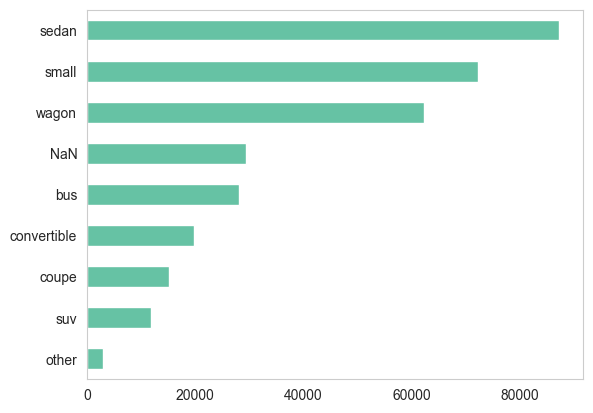

In [41]:
df['vehicle_type'].fillna('NaN').value_counts()[::-1].plot.barh(color='#66c2a4', grid=False);

Почти 40000 тысяч пропусков. Проверим, можно ли их заполнить наиболее популярным типом кузова для данной модели

In [42]:
def grouper(data, columns_group, column_res):
    return df.groupby([columns_group, column_res])[column_res].count().to_frame()

In [43]:
grouper(data=df, columns_group='model', column_res='vehicle_type').head(20)

vehicle_type
model            vehicle_type              
alfa_romeo 145   coupe                    2
                 other                    1
                 sedan                   10
                 small                   14
alfa_romeo 147   coupe                   26
                 other                    6
                 sedan                  357
                 small                   93
                 wagon                    2
alfa_romeo 156   coupe                    3
                 other                    1
                 sedan                  244
                 small                    2
                 wagon                  275
alfa_romeo 159   sedan                   55
                 wagon                  143
alfa_romeo other convertible              1
                 coupe                  194
                 other                    5
                 sedan                  202

Видно, что для большинства автомобилей есть выраженный наиболее популярный тип кузова.

Напишем функцию для заполнения нанов на основании наиболее популярного значения в группировке соседнего признака

In [44]:
# Функция реализована очень тупо. Таблицы мерджатся, а потом наны заполняются по новой колонке и она удаляется

def filler(data, columns_group, column_res):

    pivot = data.groupby(columns_group)[column_res].agg(pd.Series.mode).to_frame()
    pivot.columns = ['res' for column in pivot.columns]
    # Далее обработка на случай, если мода - это массив из нескольких значений. Берем последнее значение (это обычно седан)
    for i, row in enumerate(pivot['res']):
        if type(row)==np.ndarray:
            pivot.iloc[i, :] = row[-1]

    data = data.merge(pivot, left_on=columns_group, right_index=True, how='left')
    data[column_res] = data[column_res].fillna(data['res'])
    data = data.drop('res', axis=1)

    return data

In [45]:
print(f'Нанов было {df["vehicle_type"].isna().sum()}')
df = filler(data=df, columns_group='model', column_res='vehicle_type')
print(f'Осталось {df["vehicle_type"].isna().sum()} Нанов')

Нанов было 29295
Осталось 0 Нанов


## registration_year

In [46]:
df['registration_year'].round(-2).value_counts().head(15)

2000     328288
1900         88
1000         22
10000        12
5000          9
6000          5
1800          4
1600          3
7000          3
4500          2
3000          2
5600          2
2500          2
5900          2
4000          2
Name: registration_year, dtype: int64

в 2000-ые или хотя бы в 1900-ые было выпущено большинство машин. Тем не менее, достаточно много машин имеют неадекватный год выпуска. Заменим его на медианный для комбинации марка-модель на кросс-валидации

Убедимся, что наше предположение о невысокой дисперсии года выпуска для сочетания марка-модель верно. Возьмем только машины, выпущенные в адекватные 1920-2019 годы и те, для которых указана модель. Поверим, что кто-то продает столетний раритет

In [47]:
lifecycle = df[(df['registration_year'].between(1920, 2019)) & ~df['model'].str.contains('other')]

In [48]:
lifecycle.groupby('model')['registration_year'].agg(['count', 'std']).sort_values(by='std', ascending=False)

,count,std
model,,
land_rover serie_2,8,18.493242
ford mustang,162,17.062383
fiat 500,893,12.916056
porsche 911,64,12.476794
volkswagen kaefer,396,11.928255
...,...,...
ford b_max,26,1.022817
mercedes_benz gl,12,0.717741
daihatsu materia,18,0.685994


В основном в таблицу попали не очень массово выпускавшиеся/раритетные машины. Посмотрим на годы жизни этих линеек и следом сравним с машинами, которые выпускались не так долго

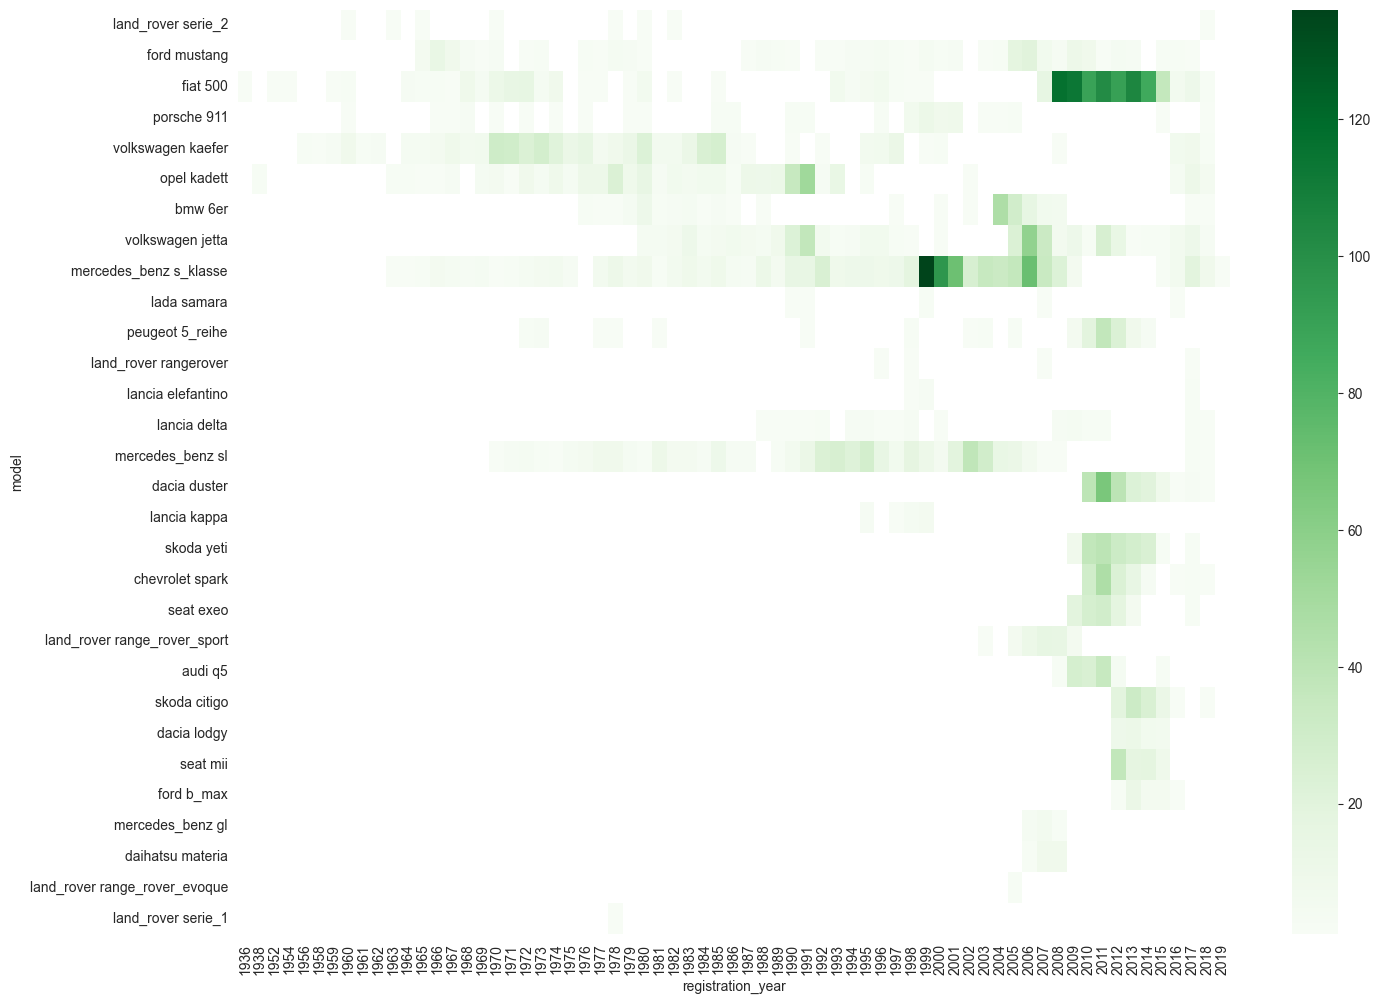

In [49]:
top_models = lifecycle.groupby('model')['registration_year'].agg(['count', 'std']).sort_values(by='std', ascending=False).index[:15].to_list() + lifecycle.groupby('model')['registration_year'].agg(['count', 'std']).sort_values(by='std', ascending=False).index[-15:].to_list()


fig, ax = plt.subplots(1, 1, figsize=(16, 12))
sns.heatmap(lifecycle[lifecycle['model'].isin(top_models)].pivot_table(values='price', index='model', columns='registration_year', aggfunc='count').reindex(top_models),
            cmap='Greens');
ax.grid(False)

В верхней половине графика модели с высокой дисперсией, в нижней - с низкой. Теперь посмотрим на дисперсию года выпуска массово выпускавшихся машин

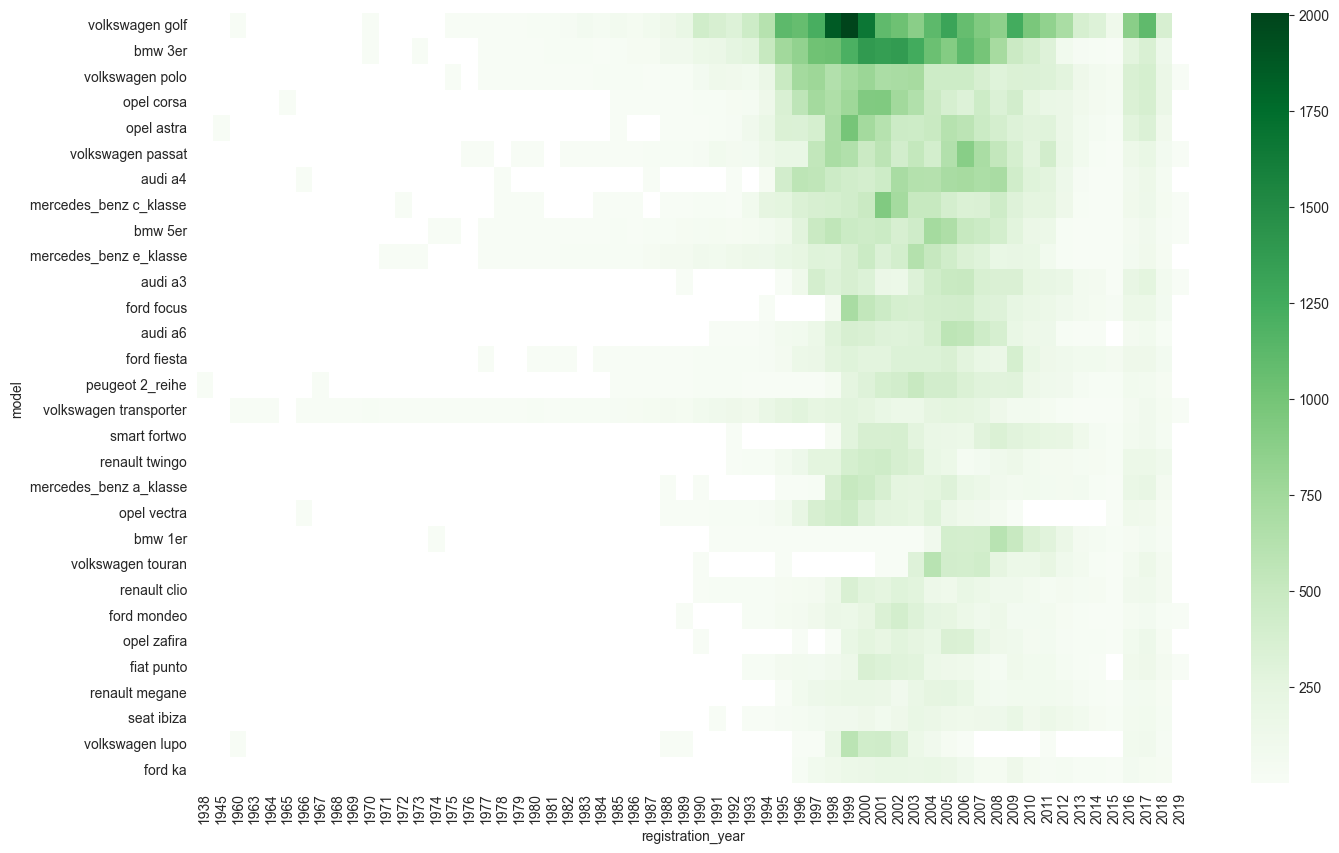

In [50]:
top_models = lifecycle.groupby('model')['registration_year'].agg(['count', 'std']).sort_values(by='count', ascending=False).index[:30].to_list()


fig, ax = plt.subplots(1, 1, figsize=(16, 10))
sns.heatmap(lifecycle[lifecycle['model'].isin(top_models)].pivot_table(values='price', index='model', columns='registration_year', aggfunc='count').reindex(top_models),
            cmap='Greens');
ax.grid(False)

Из двух графиков следует, что некоторые машины, такие как Фольксваген Транспортер стабильно равными партиями выпускаются в течение несколкьих десятков лет, другие становились популярны не сразу или переживали серьезную доработку (Фиат 500). К производству третьих компании впоследствии возвращались (Фольксваген Джетта). С другой стороны, в нашем распоряжении всего лишь выборка машин с сайта по их продаже, и пробелы на жизненном цикле линейки говорят лишь об отсутствии таких машин в продаже на данном сайте. В любом случае, делаем вывод о возможности замены года выпуска медианой (из-за скошенности данных). Но лишь в процессе кросс-валидации.

В данных много выбросов, заменим их на наны. За правую границу возьмем текущий год, но позже сравним год выпуска с имеющимися датами

In [51]:
df.loc[~df['registration_year'].between(1920, 2023), 'registration_year'] = np.nan

Посмотрим на зависимость цены от года выпуска машины. Есть предположение, что раритетные машины должны стоить также много, как и прошлогодние


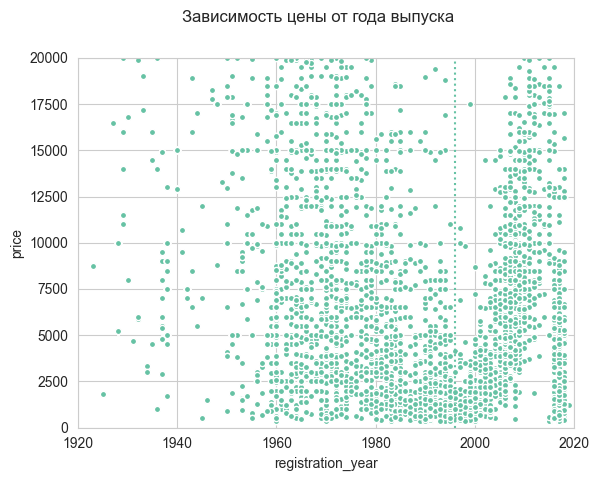

In [52]:
df.groupby(df['registration_year'].round(-1)).apply(lambda gr: gr.sample(555, replace=True)).reset_index(drop = True).plot(x='registration_year', y='price', kind='scatter', ec='w', color='#66c2a4');
plt.axvline(1996, color='#66c2a4', linestyle=':');
plt.ylim([0, 20000])
plt.xlim([1920, 2020])
plt.suptitle('Зависимость цены от года выпуска');

Так и есть! С наступлением тридцатилетия (действия происходят в 2016) автомобили начинают дорожать. Скорее всего бустинги бы заметили это и так, а вот для линейных моделей это будет неплохим булевым признаком. Кстати, на графике как будто прослеживается парабола, учтем это при обучении линейных моделей

In [53]:
df['vintage'] = df['registration_year']<1996
df

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen,latitude,longitude,population,vintage
0,2016-03-24 11:52:17,480,sedan,1993.0,manual,0,volkswagen golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,70435,2016-04-07 03:16:57,48.800050,9.174450,NaN,True
1,2016-03-24 10:58:45,18300,coupe,2011.0,manual,190,audi other,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954,2016-04-07 01:46:50,49.207100,7.591100,43582.0,False
2,2016-03-14 12:52:21,9800,suv,2004.0,auto,163,jeep grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,90480,2016-04-05 12:47:46,49.437100,11.119400,515543.0,False
3,2016-03-17 16:54:04,1500,small,2001.0,manual,75,volkswagen golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17,49.568000,10.885600,23319.0,False
4,2016-03-31 17:25:20,3600,small,2008.0,manual,69,skoda fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,60437,2016-04-06 10:17:21,50.192400,8.675300,650000.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,2016-03-27 20:36:20,1150,bus,2000.0,manual,0,opel zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,26624,2016-03-29 10:17:23,53.475527,7.351636,NaN,False
354365,2016-03-14 17:48:27,2200,sedan,2005.0,NaN,0,sonstige_autos other,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,39576,2016-04-06 00:46:52,52.606900,11.858700,37722.0,False
354366,2016-03-05 19:56:21,1199,convertible,2000.0,auto,101,smart fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,26135,2016-03-11 18:17:12,53.126700,8.238400,159218.0,False
354367,2016-03-19 18:57:12,9200,bus,1996.0,manual,102,volkswagen transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,87439,2016-04-07 07:15:26,47.717700,10.298900,NaN,False


Посмотрим, сколько в каждом кластере наблюдений

In [54]:
df['vintage'].value_counts(normalize=True)

False    0.909785
True     0.090215
Name: vintage, dtype: float64

## gearbox

In [55]:
df['gearbox'].value_counts(dropna=False)

manual    249993
auto       64056
NaN        14422
Name: gearbox, dtype: int64

Заменим большинством

In [56]:
df['gearbox'].fillna('manual', inplace=True)

## power

У признака много выбросов.

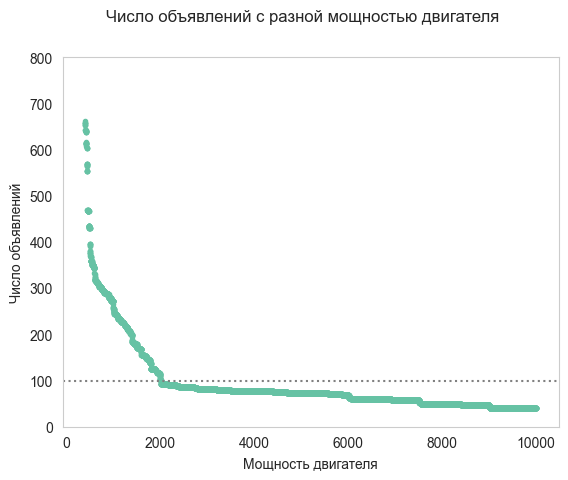

In [57]:
for thr in range(400, 10000):
    plt.plot(thr, df[df['power']>thr].shape[0], marker='.', color='#66c2a4')
    plt.grid(False)
plt.suptitle('Число объявлений с разной мощностью двигателя')
plt.ylim([0, 800])
plt.axhline(100, linestyle=':', color='grey');
plt.xlabel('Мощность двигателя')
plt.ylabel('Число объявлений');

Интересная неинтерпретируемая зависимость - объявления начинают слабее убывать примерно на отметке 2000 лс. Хотя и этот предел неадекватен мощности двигателя, можно предположить, что какие-то значения все же записаны в неправильных единицах измерения

Заменим все выбросы на Наны. Пусть адекватной мощностью двигателя будет диапазон 20...600 л.с

In [58]:
df.loc[~df['power'].between(20, 600), 'power'] = np.nan

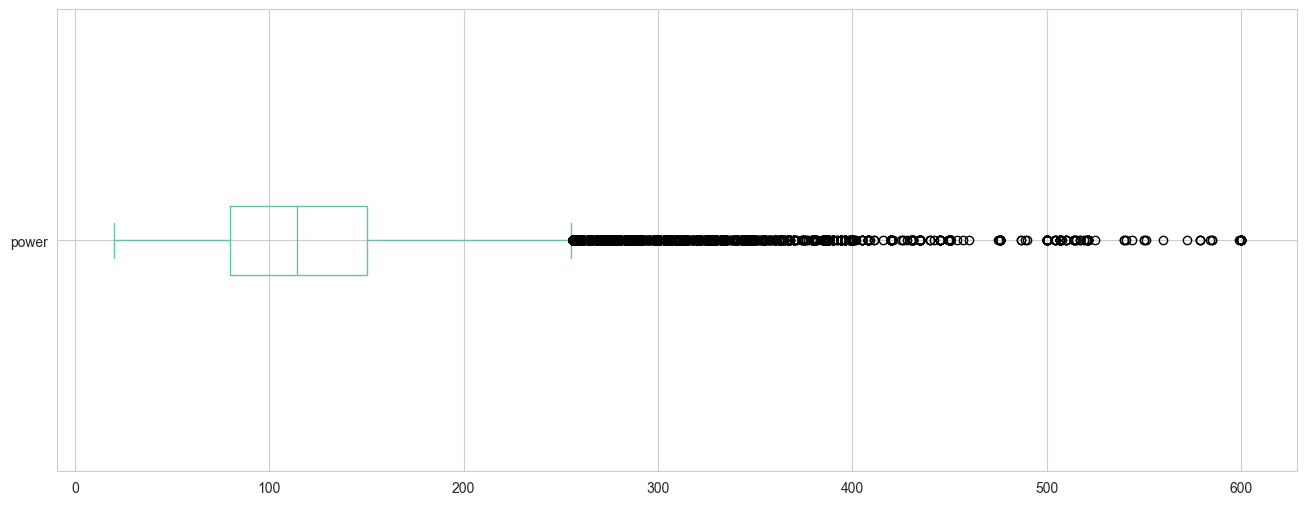

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
df['power'].plot.box(grid=True, vert=False, color='#66c2a4', ax=ax);

## kilometer

In [60]:
df['kilometer'].value_counts()

150000    219042
125000     34788
100000     13993
90000      11175
80000       9753
70000       8376
60000       7303
50000       6086
40000       4815
30000       4240
5000        4189
20000       3652
10000       1059
Name: kilometer, dtype: int64

Значения дискретны, и значение 150000 несет смысл "более 150 тыс км". закодируем их через OrdinalEncoder.

## registration_month

In [61]:
df['registration_month'].value_counts()

3     32686
6     29899
4     27728
5     27596
0     27467
7     25908
10    24942
11    23159
12    23079
9     22718
1     21714
8     21509
2     20066
Name: registration_month, dtype: int64

Месяцев получилось тринадцать! Наверное, значение 0 можно интерпретировать как "неизвестно", тем более его значение немного превышает все остальные. Сам по себе месяц выпуска/регистрации машины не должен ни с чем коррелировать, но вот информация о том, известен ли месяц, может означать наличие нормальных документов на машину. Попробуем закодировать этот признак бинарно дополнительно к основному (банарная кодировка сильнее коррелирует с таргетом, это будет видно дальше), а потом спросим у заказчика, что это всё значит и откуда брать признак для будущих объявлений

In [62]:
df['registration_month_bool'] = df['registration_month']>0

## fuel_type

In [63]:
df['fuel_type'].value_counts(dropna=False, normalize=True)

petrol      0.610511
gasoline    0.293974
NaN         0.077014
lpg         0.015505
cng         0.001641
hybrid      0.000685
other       0.000414
electric    0.000256
Name: fuel_type, dtype: float64

В списке отсутствует дизель, но понадеемся, что он скрывается за одним из терминов gasoline/petrol, потому что если переводить дословно, то оба они - бензин. А вот маленькие категории объединим в other

Заполним тип топлива наиболее частым для данной модели

In [64]:
grouper(data=df, columns_group='model', column_res='fuel_type').head(44)

fuel_type
model             fuel_type           
alfa_romeo 145    petrol            31
alfa_romeo 147    gasoline         132
                  lpg               17
                  petrol           384
alfa_romeo 156    gasoline         179
                  lpg               14
                  petrol           323
alfa_romeo 159    gasoline         138
                  petrol            58
alfa_romeo other  gasoline         126
                  lpg                3
                  petrol           398
alfa_romeo spider gasoline          11
                  lpg                1
                  petrol           164
audi 100          gasoline          15
                  lpg                8
                  petrol           323
audi 200          petrol            16
audi 80           gasoline          76
                  lpg               21
                  petrol          1126
audi 90           petrol            74
audi a1           gasoline         171
                  petrol           413
audi a2           gasoline         157
                  petrol           205
audi a3           gasoline        2367
                  lpg               38
                  petrol          3282
audi a4           electric           2
                  gasoline        4709
                  hybrid             1
                  lpg              132
                  other              1
                  petrol          4127
audi a5           gasoline         326
                  petrol           195
audi a6           cng                1
                  gasoline        3427
                  lpg              158
                  petrol          1468
audi a8           gasoline         220
                  lpg               42

In [65]:
print(f'Нанов было {df["fuel_type"].isna().sum()}')
df = filler(data=df, columns_group='model', column_res='fuel_type')
print(f'Осталось {df["fuel_type"].isna().sum()} Нанов')

Нанов было 25297
Осталось 0 Нанов


Остатки заполним

In [66]:
df.loc[df['fuel_type'].isin(['lpg', 'cng', 'hybrid', 'electric']), 'fuel_type'] = 'other'

Посмотрим, что получилось

In [67]:
df['fuel_type'].value_counts(dropna=False, normalize=True)

petrol      0.673834
gasoline    0.307665
other       0.018501
Name: fuel_type, dtype: float64

## not_repaired

In [68]:
df['not_repaired'].value_counts(dropna=False)

no     240479
NaN     58821
yes     29171
Name: not_repaired, dtype: int64

Отнесем наны к неремонтированным машинам

In [69]:
df['not_repaired'] = df['not_repaired'].fillna('yes')

In [70]:
df['not_repaired'] = df['not_repaired'].replace({'yes': 1, 'no': 0}).astype('bool')

## date_created и last_seen

Переведем колонки в тип даты

In [71]:
df['date_created'] = pd.to_datetime(df['date_created'])
df['last_seen'] = pd.to_datetime(df['last_seen'])

В датасете несколько столбцов с датами, давайте проверим, все ли даты правильно упорядочены во времени

In [72]:
df[~((df['registration_year']<=df['date_created'].dt.year) &
   (df['date_created'].dt.year<=df['last_seen'].dt.year) &
   (df['last_seen'].dt.year<=df['date_crawled'].dt.year))]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen,latitude,longitude,population,vintage,registration_month_bool
15,2016-03-11 21:39:15,450,small,NaN,manual,NaN,ford ka,5000,0,petrol,ford,True,2016-03-11,24148,2016-03-19 08:46:47,54.318700,10.170300,246601.0,False,False
22,2016-03-23 14:52:51,2900,bus,2018.0,manual,90.0,opel meriva,150000,5,petrol,opel,False,2016-03-23,49716,2016-03-31 01:16:33,52.690600,7.291000,34198.0,False,True
26,2016-03-10 19:38:18,5555,sedan,2017.0,manual,125.0,citroen c4,125000,4,gasoline,citroen,False,2016-03-10,31139,2016-03-16 09:16:46,52.141000,9.940700,103052.0,False,True
48,2016-03-25 14:40:12,7750,sedan,2017.0,manual,80.0,volkswagen golf,100000,1,petrol,volkswagen,True,2016-03-25,48499,2016-03-31 21:47:44,52.325600,7.430500,7602.0,False,True
51,2016-03-07 18:57:08,2000,small,2017.0,manual,90.0,fiat punto,150000,11,gasoline,fiat,True,2016-03-07,66115,2016-03-07 18:57:08,49.239900,6.969600,179349.0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354112,2016-03-11 15:49:51,3600,bus,2017.0,manual,86.0,ford transit,150000,5,gasoline,ford,True,2016-03-11,32339,2016-03-12 05:45:02,52.382500,8.621300,26378.0,False,True
354140,2016-03-29 16:47:29,1000,wagon,2017.0,manual,101.0,audi a4,150000,9,gasoline,audi,True,2016-03-29,38315,2016-04-06 02:44:27,52.034850,10.543900,NaN,False,True
354203,2016-03-17 00:56:26,2140,small,2018.0,manual,80.0,ford fiesta,150000,6,petrol,ford,False,2016-03-17,44866,2016-03-29 15:45:04,51.480800,7.148600,385729.0,False,True
354253,2016-03-25 09:37:59,1250,small,2018.0,manual,NaN,opel corsa,150000,0,petrol,opel,True,2016-03-25,45527,2016-04-06 07:46:13,51.400000,7.166700,56866.0,False,False


Почти 15 тыс объявлений не упорядочены. Без лишних выкладок скажем, что во всех них дата регистрации позже даты создания объявления, последнего посещения и его скачивания. Заменим в таких объявлениях год регистрации на nan

In [73]:
df.loc[~((df['registration_year']<=df['date_created'].dt.year) &
   (df['date_created'].dt.year<=df['last_seen'].dt.year) &
   (df['last_seen'].dt.year<=df['date_crawled'].dt.year)), 'registration_year'] = np.nan

Наконец, удалим вспомогательные столбцы и посмотрим, что осталось от датасета

In [74]:
df = df.drop(['date_crawled', 'date_created', 'last_seen', 'postal_code'], axis=1)

In [75]:
full_info(df)

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
price,328471,0,int64,328471.0,4756.24337,4517.209198,301.0,1350.0,3000.0,6800.0,20000.0
vehicle_type,328471,0,object,,,,,,,,
registration_year,315009,13462,float64,315009.0,2002.785632,6.752968,1923.0,1999.0,2003.0,2007.0,2016.0
gearbox,328471,0,object,,,,,,,,
power,296555,31916,float64,296555.0,121.67082,53.64183,20.0,80.0,114.0,150.0,600.0
model,328471,0,object,,,,,,,,
kilometer,328471,0,int64,328471.0,128301.326449,37160.167991,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,328471,0,int64,328471.0,5.867175,3.662016,0.0,3.0,6.0,9.0,12.0
fuel_type,328471,0,object,,,,,,,,
brand,328471,0,object,,,,,,,,


В годе выпуска и мощности двигателя пропусков не было, а теперь появились из-за переноса выбросов в нан. Со всем остальным наоборот, пропуски удалось заполнить

## Корреляции признаков

Посмотрим, как коррелируют друг с другом числовые признаки

CPU times: total: 18.3 s
Wall time: 18.4 s


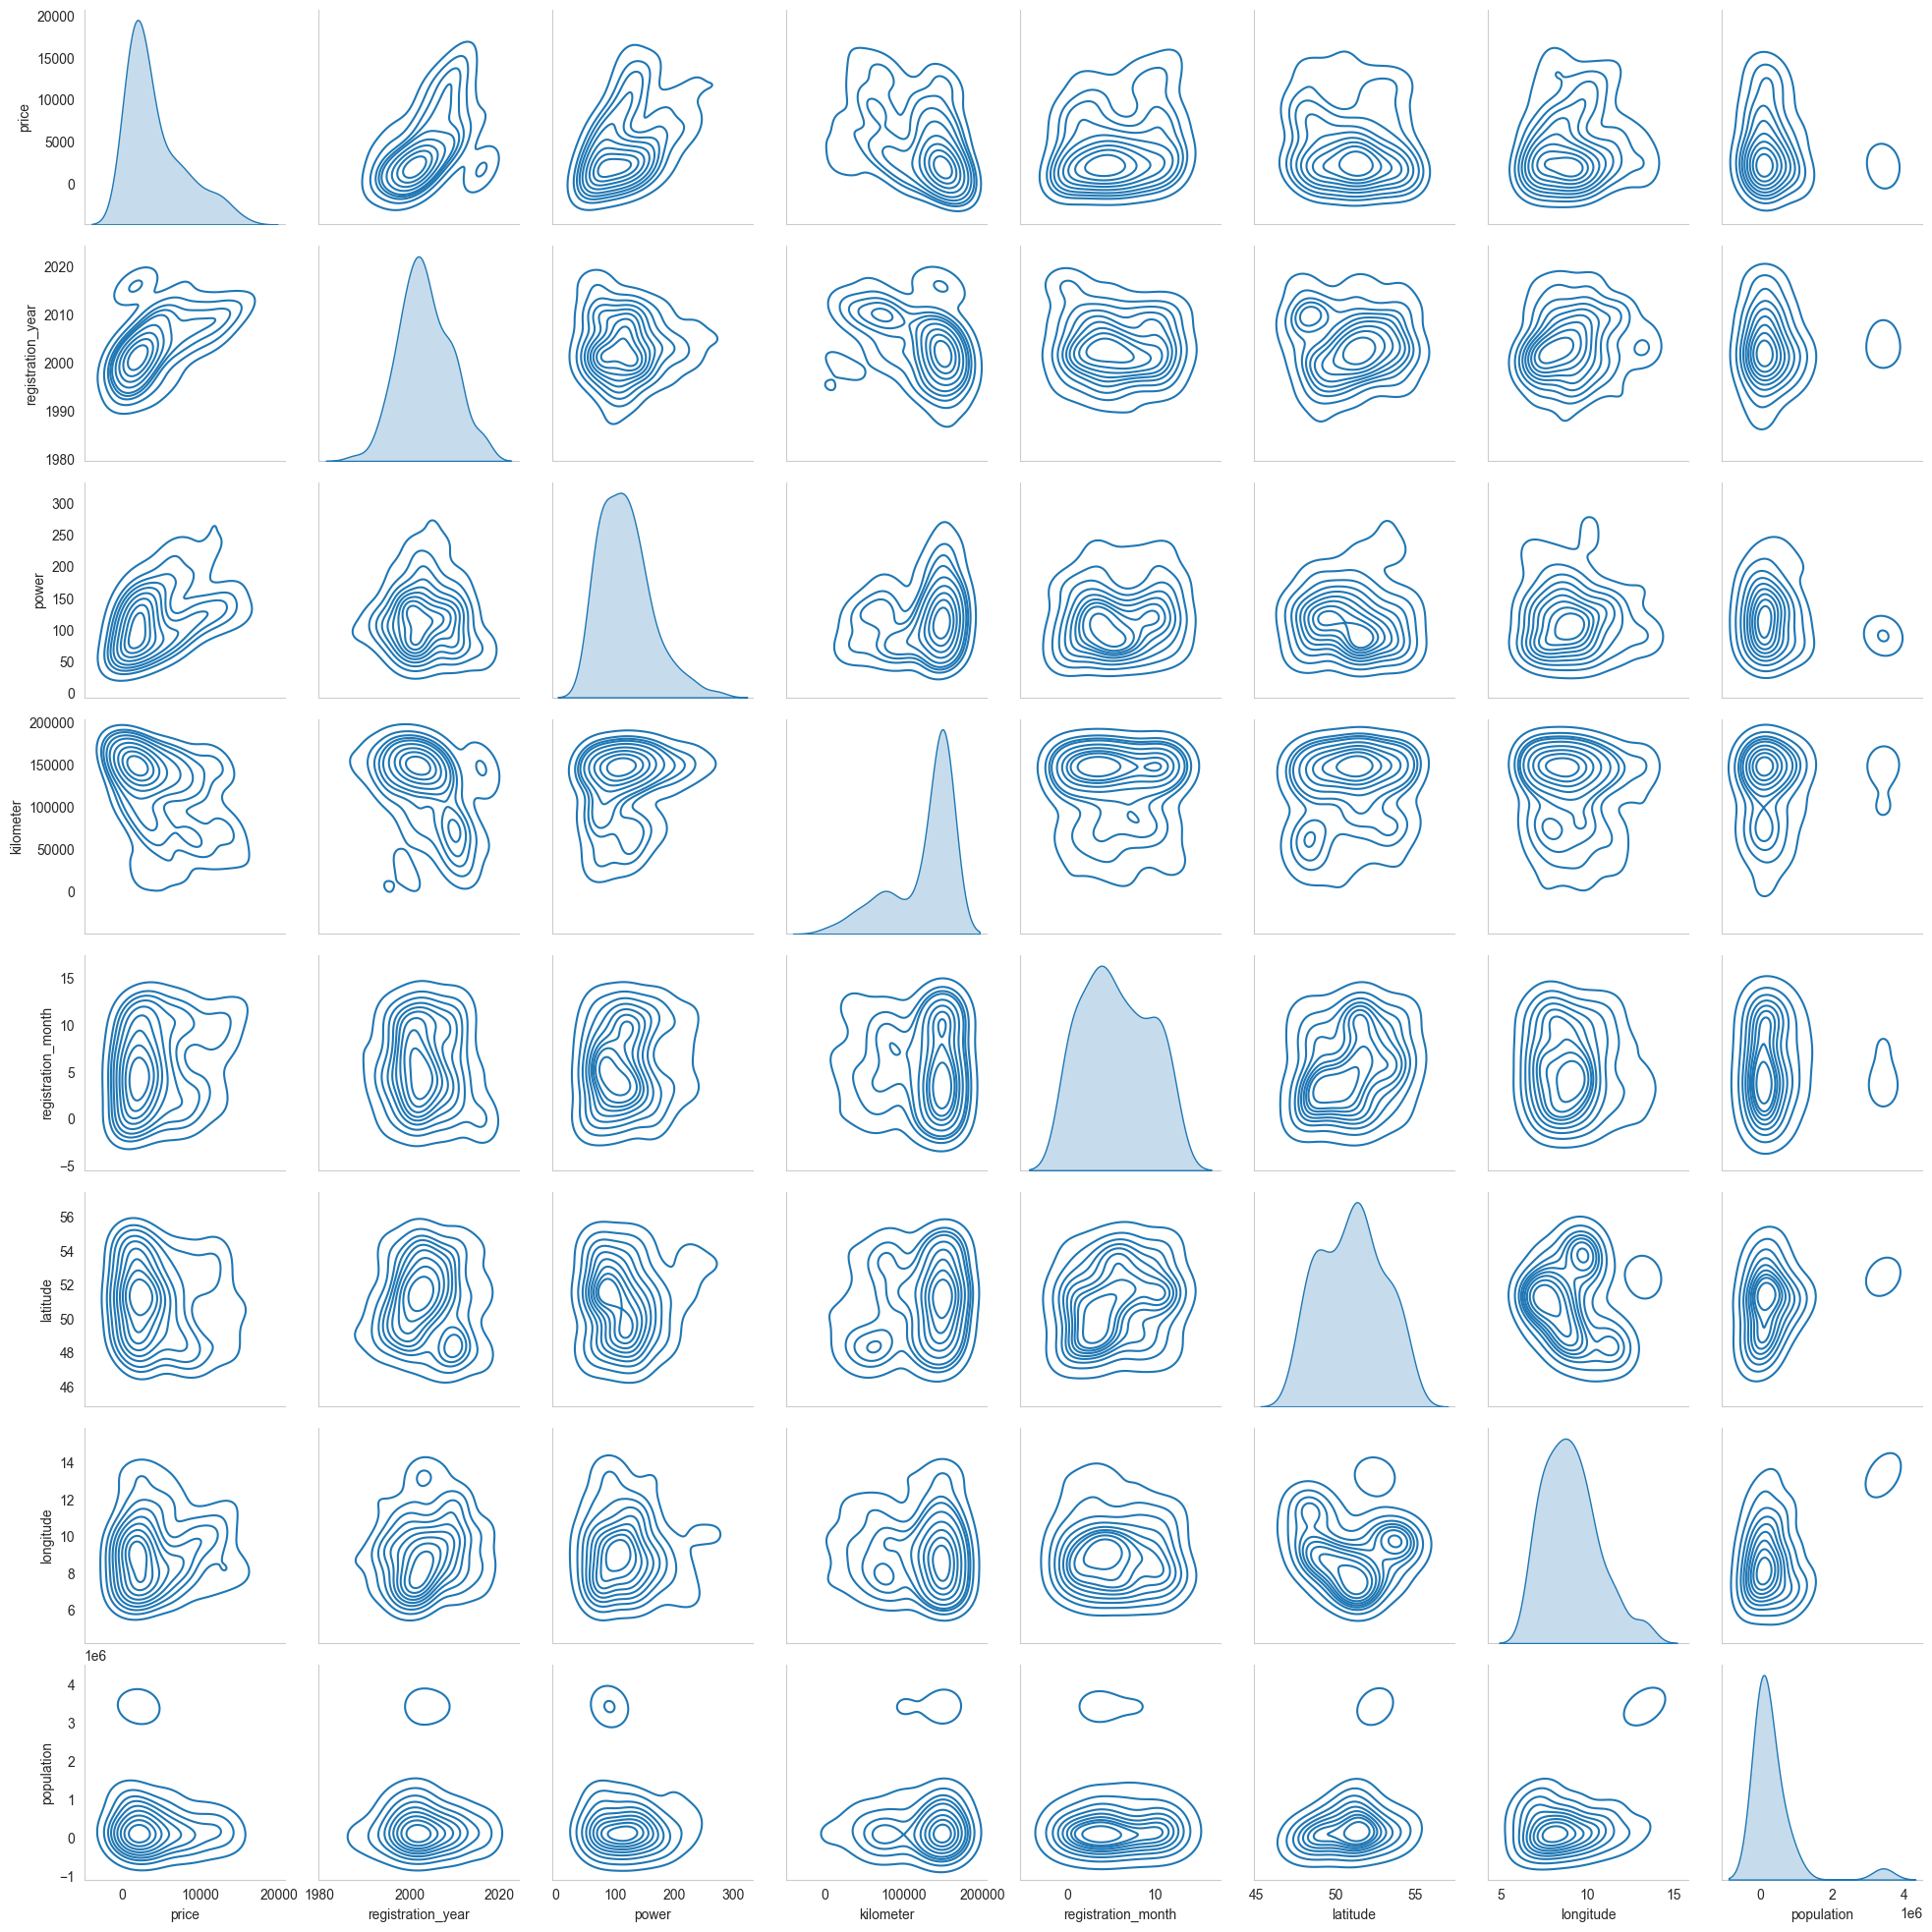

In [76]:
%%time
sns.set_style("whitegrid", {'axes.grid' : False})
sns.pairplot(df.select_dtypes(exclude=['object', 'bool']).sample(111), kind='kde');

Посмотрим на значения коэффициента линейной корреляции

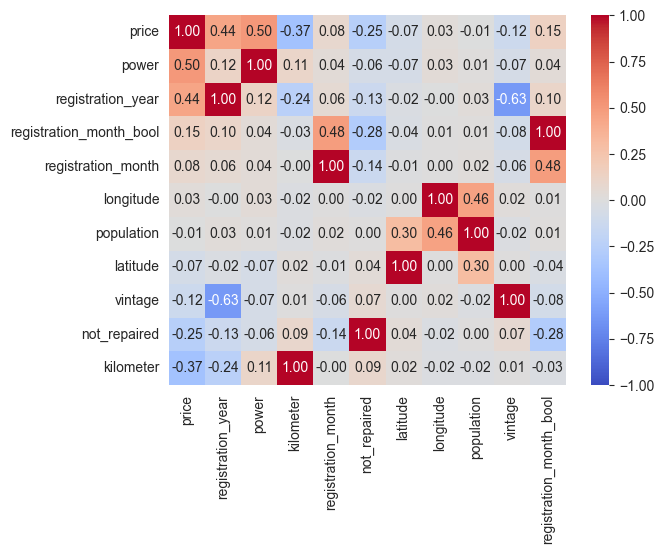

In [77]:
sns.heatmap(df.select_dtypes(exclude='object').corr().sort_values('price', ascending=False),
            vmin=-1, vmax=1,
            cmap='coolwarm',
            annot=True,
            fmt='.2f');

А теперь посмотрим на нелинейные корреляции

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer', 'registration_month', 'latitude', 'longitude', 'population']


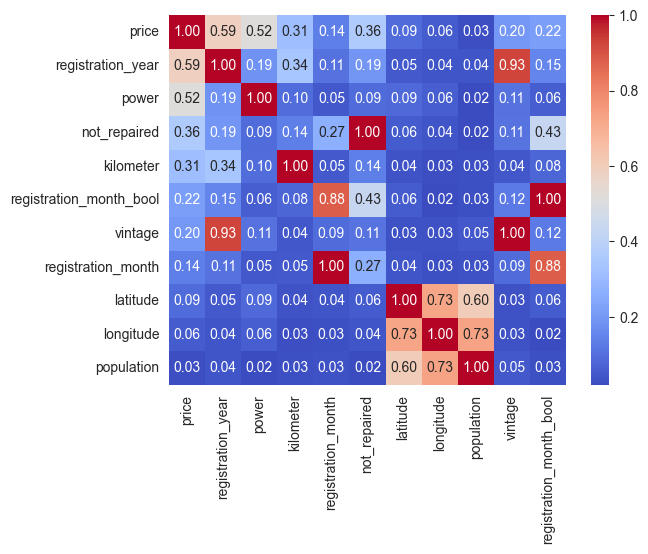

In [78]:
sns.heatmap(df.select_dtypes(exclude='object').phik_matrix().sort_values('price', ascending=False),
            cmap='coolwarm',
            annot=True,
            fmt='.2f');

По обоим хитмэпам видно, что геоданные, которые мы так тщательно добывали, коррелируют только друг с другом. Но зато месяц регистрации, который мы закодировали бинарно, имеет неплохую корреляцию, его и оставим

In [79]:
try:
    df = df.drop(['registration_month', 'latitude', 'longitude', 'population'], axis=1).reset_index(drop=True)
except:
    pass

In [80]:
full_info(df)

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
price,328471,0,int64,328471.0,4756.24337,4517.209198,301.0,1350.0,3000.0,6800.0,20000.0
vehicle_type,328471,0,object,,,,,,,,
registration_year,315009,13462,float64,315009.0,2002.785632,6.752968,1923.0,1999.0,2003.0,2007.0,2016.0
gearbox,328471,0,object,,,,,,,,
power,296555,31916,float64,296555.0,121.67082,53.64183,20.0,80.0,114.0,150.0,600.0
model,328471,0,object,,,,,,,,
kilometer,328471,0,int64,328471.0,128301.326449,37160.167991,5000.0,125000.0,150000.0,150000.0,150000.0
fuel_type,328471,0,object,,,,,,,,
brand,328471,0,object,,,,,,,,
not_repaired,328471,0,bool,,,,,,,,


# Разделение на обучающую и тестовую выборки

In [81]:
x = df.drop('price', axis=1)
y = df['price']

In [82]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rs)

# Создание кастомной метрики

In [83]:
def rmse(y_true, y_pred):
    return (mean_squared_error(y_true, y_pred, squared=False))
rmse_score = make_scorer(rmse, greater_is_better=False)

# Написание пользовательских классов

## FrequencyEncoder

In [600]:
# https://medium.com/@benlc77/how-to-write-clean-and-scalable-code-with-custom-transformers-sklearn-pipelines-ecb8e53fe110

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    # наследуемся от BaseEstimator, TransformerMixin, чтобы были базовые методы фит-трансформ и get_params
    def __init__(self):
        pass

    def fit(self, x, y=None):
        vc = []
        self.x = x
        self.features = x.columns
        for feature in self.features:
            vc.append(x[feature].value_counts())
        self.vc = vc
        return self

    def transform(self, x, y=None):
        # нолики
        x_tr = np.zeros(shape=x_train.shape[0])
        for feature, t in zip(self.features, self.vc):
            x_tr = np.vstack([x_tr, x[feature].transform(lambda i: t.loc[i] if i in t.index else 0)])

        # Первая строчка нолики, со второй - трансформированные фичи
        return x_tr[1:].T

In [597]:
# Нужен для того, чтобы искомый столбец встал первым по счету

class LazyEncoder(BaseEstimator, TransformerMixin):
    # наследуемся от BaseEstimator, TransformerMixin, чтобы были базовые методы фит-трансформ и get_params
    def __init__(self):
        pass

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        return x

Напишем класс, который будет разделять датасет по определенному категориальному признаку и строить свою линейную регрессию для каждого уникального значения в этой категории - своеобразный биннинг. А еще добавим возможность приводить выбивающиеся за разумные рамки значения к установленным границам

In [515]:
# МОЖНО ПОПРОБОВАТЬ ДЕЛИТЬ ДАТАСЕТ ПО ПЕРВОМУ ПРИЗНАКУ, А В ТРАНСФОРМЕР НА ПЕРВОМ МЕСТЕ ПОСТАВИТЬ ТРАНСФОМЕР, КОТОРЫЙ ВОЗВРАЩАЕТ ПРИЗНАК БЕЗ ИЗМЕНЕНИЙ
class BinClipLinearRegression():
    def __init__(self, feature=None, columns=None, take_first=False, clip=False):
        # Если передается датафрейм, то достаточно указать признак. А если нп.аррей, то нужно дать названия колонкам
        # Если take_first=True, то берется первый столбец
        self.columns=columns
        self.take_first=take_first
        if self.columns: # проверяем не называется ли фича теперь как-то по-другому, ищем имя типа num_ct__feature
            self.feature = [i for i in columns if feature in i][0]
        elif feature:
            self.feature = feature
        else:
            self.feature = 0
        self.clip = clip

    def fit(self, x, y, ymin=y.min(), ymax=y.max()):
        if self.take_first:
            self.columns = [i for i in range(x.shape[1])]

        if self.columns:
            x = pd.DataFrame(x, columns=self.columns)
            try: # это если передан Series с индексами
                y = y.reset_index(drop=True)
            except: # а это если любая другая структура без индексов
                pass
        self.uniques = x[self.feature].unique()

        self.ymin = ymin
        self.ymax = ymax
        models = {}

        for f in self.uniques:
            xx = x[x[self.feature]==f]
            yy = y[xx.index]
            models[f] = LinearRegression().fit(xx, yy)
        self.models = models
        # return xx
        return self

    def predict(self, x):
        if self.columns:
            x = pd.DataFrame(x, columns=self.columns)
        x = x.reset_index(drop=True)
        # создаем пустую матрицу
        y_pred = np.full([x.shape[0], 1], np.nan)
        for f in self.uniques:
            y_pred[x[x[self.feature]==f].index, :] = self.models[f].predict(x[x[self.feature]==f]).reshape(-1, 1)
        # Заполнение нанов медианой, если вдруг на тестовой выборке встретилась категория, которой не было на обучении
        y_pred[np.where(np.isnan(y_pred))] = np.nanmedian(y_pred)

        if self.clip:
            return np.clip(y_pred, self.ymin, self.ymax)
        return y_pred

In [521]:
aa = np.array([[1,2,2], [1,3,4], [2,4,5], [4,5,7], [5,6,8], [6,8,10]])
cols = [4, 'yyyy', 'wwww']
pd.DataFrame(aa, columns=cols)

,4,yyyy,wwww
0,1,2,2
1,1,3,4
2,2,4,5
3,4,5,7
4,5,6,8
5,6,8,10


In [522]:
rr = BinClipLinearRegression(take_first=True)
rr.fit(aa, np.array([1,2,3,4,5,7]))
rr.models

{1: LinearRegression(),
 2: LinearRegression(),
 4: LinearRegression(),
 5: LinearRegression(),
 6: LinearRegression()}

In [523]:
rr.predict(aa)

array([[1.],
       [2.],
       [3.],
       [4.],
       [5.],
       [7.]])

In [530]:
x_train[['vintage', 'registration_year' ]].values

array([[False, 2007.0],
       [False, 2003.0],
       [False, 2010.0],
       ...,
       [False, 2005.0],
       [False, 1998.0],
       [False, 2005.0]], dtype=object)

In [542]:
lrc = BinClipLinearRegression(take_first=True)
tt = lrc.fit(x_train[['vintage', 'registration_year' ]].fillna(2000).values, y_train ** (1/3))
tt_pred = tt.predict(x_train[['vintage', 'registration_year']].fillna(2000).values) ** 3

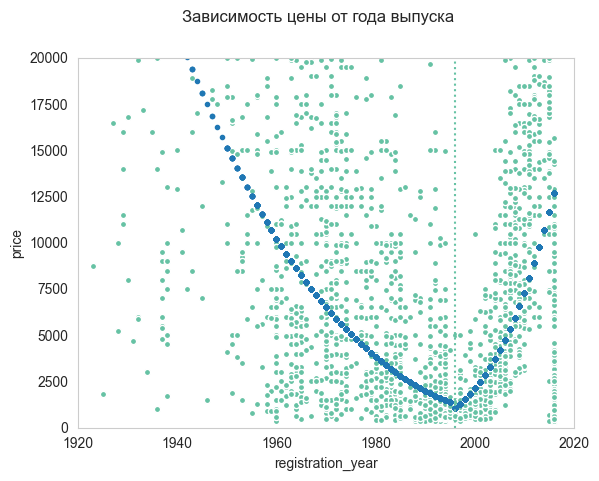

In [544]:
df.groupby(x_train['registration_year'].round(-1)).apply(lambda gr: gr.sample(300, replace=True)).reset_index(drop = True).plot(x='registration_year', y='price', kind='scatter', ec='w', color='#66c2a4');
plt.scatter(x=x_train['registration_year'], y=tt_pred, marker='.');
plt.axvline(1996, color='#66c2a4', linestyle=':');
plt.ylim([0, 20000])
plt.xlim([1920, 2020])
plt.suptitle('Зависимость цены от года выпуска');

In [604]:
num_ct_robust = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'))])

transformer = ColumnTransformer(transformers=[('lazy', LazyEncoder(), ('vintage', )),
                                              ('nums_robust', SimpleImputer(strategy='median'),                ('registration_year', 'power',)),
                                              ('cats', cat_ct, selector(dtype_include='object'))], #
                                remainder='passthrough')

lr_pipe = Pipeline([('transformer', transformer), ('estimator', BinClipLinearRegression(take_first=True))])

In [605]:
lr_pipe.fit(x_train, y_train)

ValueError: Shape of passed values is (262776, 1), indices imply (262776, 346)

In [ ]:
lr_pipe.predict(x_train)

# Обучение моделей

In [291]:
full_info(df)

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
price,328471,0,int64,328471.0,4756.24337,4517.209198,301.0,1350.0,3000.0,6800.0,20000.0
vehicle_type,328471,0,object,,,,,,,,
registration_year,315009,13462,float64,315009.0,2002.785632,6.752968,1923.0,1999.0,2003.0,2007.0,2016.0
gearbox,328471,0,object,,,,,,,,
power,296555,31916,float64,296555.0,121.67082,53.64183,20.0,80.0,114.0,150.0,600.0
model,328471,0,object,,,,,,,,
kilometer,328471,0,int64,328471.0,128301.326449,37160.167991,5000.0,125000.0,150000.0,150000.0,150000.0
fuel_type,328471,0,object,,,,,,,,
brand,328471,0,object,,,,,,,,
not_repaired,328471,0,bool,,,,,,,,


## Линейная регрессия

In [166]:
num_ct_robust = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                ('scaler', RobustScaler(quantile_range=(15, 85)))])

num_ct_standard = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                  ('scaler', StandardScaler())])

# num_ct_ordinal = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
#                                  ('ordinal', OrdinalEncoder()),
#                                  ('scaler', StandardScaler())
#                                  ])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'))])

transformer = ColumnTransformer(transformers=[('nums_robust', num_ct_robust, ('registration_year', 'power',)),
                                              ('nums_standard', num_ct_standard, ('kilometer', )),
                                              ('cats', cat_ct, selector(dtype_include='object'))],
                                remainder='passthrough')

lr_pipe = Pipeline([('transformer', transformer), ('estimator', LinearRegression())])

In [167]:
%%time
cross_val_score(lr_pipe, x_train, y_train, scoring=rmse_score, cv=3, n_jobs=-1, error_score='raise').mean().round()

CPU times: total: 562 ms
Wall time: 16.3 s


-2673.0

Значение метрики выглядит приемлемо (отрицательное значение возникло из-за того, что максимизируется отрицательное число), но посмотрим на гистограмму

In [168]:
cv_lr_pred = cross_val_predict(lr_pipe, x_train, y_train, cv=3, n_jobs=-1)

In [172]:
cv_lr_pred

array([10155.15434261,  9460.10972893,  7590.7934019 , ...,
        5047.69345227,  2782.88657497,   701.90472147])

In [ ]:
plt.hist(cv_lr_pred, bins=50, color='#66c2a4');
plt.axvline(cv_lr_pred.min(), color='#66c2a4', linestyle=':');

Регрессия ожидаемо выдала большое количество отрицательных значений. Посмотрим, что это за значения

In [ ]:
tmp = x_train.reset_index(drop=True).loc[np.where(cv_lr_pred<300)[0], :].assign(price = y_train.reset_index(drop=True), price_pred=pd.Series(cv_lr_pred))
tmp['abs_diff'] = tmp['price'] - tmp['price_pred']

In [ ]:
plt.scatter(x=tmp['registration_year'], y=tmp['abs_diff'], color='#66c2a4', alpha=0.1, ec='w');
plt.xlabel('Год выпуска машины из объявления')
plt.ylabel('Абсолютная ошибка в цене');

График показывает, что модель все еще довольно сильно ошибается на винтажных авто, предсказывая низкое или вообще отрицательное значение.

Сделаем отдельные предсказания линейной регрессии для двух классов: винтажных и нормальных машин. Будем предсказывать корень из цены и возвращать его квадрат, то есть само значение. Это повышает предсказание примерно на 100 единиц из-за параболического графика зависимости цены от года выпуска. Можно было бы еще ridge-регрессией подобрать более подходящую степень трансформации, но тюнить линейную регрессию, когда впереди деревья, бустинги и прочие ансамбли - это трата времени

In [ ]:
tmp_x_train = x_train.copy()
for label in tmp_x_train['vintage'].unique():
    tmp_x = x_train[x_train['vintage']==label]
    tmp_y = y_train[tmp_x.index] ** 0.5
    binned_lr_pred = cross_val_predict(lr_pipe, tmp_x, tmp_y, cv=3, n_jobs=-1)
    tmp_x_train.loc[tmp_x.index, 'y_pred'] = binned_lr_pred ** (1/0.5)

Добавим к временной таблице столбцы с реальной и предсказанной ценой

In [ ]:
tmp_x_train['y_true'] = y_train
tmp_x_train['abs_diff'] = tmp_x_train['y_true'] - tmp_x_train['y_pred']

In [ ]:
rmse(tmp_x_train['y_true'], tmp_x_train['y_pred']).round()

Ошибка снизилась, посмотрим на график ошибок

In [ ]:
plt.scatter(x=tmp_x_train[tmp_x_train['y_pred']<300]['registration_year'],
            y=tmp_x_train[tmp_x_train['y_pred']<300]['abs_diff'],
            color='#66c2a4', alpha=0.1, ec='w');
plt.xlabel('Год выпуска машины из объявления')
plt.ylabel('Абсолютная ошибка в цене');

Модель практически не оценила винтажные машины меньше нуля! Но в диапазоне 1994-2002 много больших положительных значений, то есть у них реальная цена сильно выше предсказанной, а так как предсказанная меньше установленных 300, то ее можно искусственно привести к границам [300, 20000], тем самым еще сильнее понизив ошибку. Посмотрим, как изменится метрика

In [ ]:
rmse(tmp_x_train['y_true'], np.clip(tmp_x_train['y_pred'], 300, 20000)).round()

Стало на 350 евро лучше относительно бейзлайна

## Случайный лес

In [ ]:
num_ct_median = Pipeline(steps=[('median_imputer', SimpleImputer(strategy='median'))])

cat_ct = Pipeline(steps=[('ohe', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'))])

transformer = ColumnTransformer(transformers=[('nums_imputer', num_ct_median, ('registration_year', 'power',)),
                                              ('cats', cat_ct, selector(dtype_include='object'))],
                                remainder='passthrough')

rf_pipe = Pipeline([('transformer', transformer), ('estimator', RandomForestRegressor())])

params = {'estimator__max_depth': (3, 5, 7)}

gs = GridSearchCV(rf_pipe, param_grid=params, scoring=rmse_score, cv=3, n_jobs=-1)

In [ ]:
gs.fit(x_train, y_train)

In [ ]:
num_ct_median = Pipeline(steps=[('median_imputer', SimpleImputer(strategy='median'))])

cat_ct = Pipeline(steps=[('ohe', FrequencyEncoder())])

tra = ColumnTransformer(transformers=[('nums_imputer', num_ct_median, ('registration_year', 'power',)),
                                      ('cats', cat_ct, selector(dtype_include='object'))],
                                remainder='passthrough')